# visualizing the images

In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets_v2.mri_dataset_inram import MRISegmentation3DDataset
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading ADNI flair t1 mask dataset

In [3]:
ADNI_ds = MRISegmentation3DDataset("/home/s2208943/preprocessed_data/ADNI300/collated", no_labels=True, xy_only=False)

In [4]:
IDs = [v[2] for v in ADNI_ds]

### Loading ADNI predictions

In [5]:
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True, ncols=100):
        # print(fID)
        # break
        if ".npz" in fID and "model_WMH_samples" not in fID:
            ID = fID.split("_out_maps")[0]
            output_maps_data = np.load(os.path.join(output_maps_dir,fID))
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                if key == "seg":
                    continue
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [16]:
# model_name = "SSN_Ens_Mean"
output_maps = {}
for model_name in ["nnunet/nnunetSsnEns2D", "nnunet/nnunet2D"]:
    output_maps_dir = f"/home/s2208943/preprocessed_data/ADNI300/ADNI_300_output_maps/{model_name}/"
    out_maps, key_order = load_output_maps(output_maps_dir)
    output_maps[model_name] = out_maps

100%|█████████████████████████████████████████████████████████████| 290/290 [00:29<00:00,  9.94it/s]


### Loading the Fazekas Categories

In [8]:
from trustworthai.journal_run.new_MIA_fazekas_and_QC.dataset_setup import *

In [9]:
cvd_data, adni_data, challenge_data, mss3_data = load_spreadsheets(include_MSS3=True)

challenge shapes before and after cleanup
(175, 1532)
(175, 1465)
cvd shapes before and after cleanup
(250, 1552)
(250, 1402)
adni shapes before and after cleanup
(299, 1544)
(299, 1374)
mss3 shapes before and after cleanup
(68, 46)
(68, 44)


In [10]:
IDs_map = {ID:"_".join(ID.split("_")[1:4]) for ID in IDs}
reverse_IDs_map = {value:key for key, value in IDs_map.items()}

In [11]:
adni_data['ssn_ens'][['ID', 'WMH_PV', 'WMH_Deep']][0:10]

,ID,WMH_PV,WMH_Deep
0,002_S_0729,2.0,2.0
1,002_S_1155,1.0,0.0
2,002_S_1261,1.0,1.0
3,002_S_1280,3.0,2.0
4,002_S_2010,1.0,1.0
5,002_S_4213,1.0,0.0
6,002_S_4225,1.0,1.0
7,002_S_4229,2.0,1.0
8,002_S_4237,2.0,2.0
9,002_S_4262,2.0,3.0


In [12]:
import proplot as pplt

### visualize the bias field and head movement in ADNI

In [13]:
def plot_brain_image_singlesice(ds, IDs, output_maps_ssnens, output_maps_deterministic, target_pID, df, reverse_IDs_map, islice, r1=20, r2=10, figtitles=False, savetitle=None):
    IDs = np.array(IDs)
    scan_id = np.where(IDs == reverse_IDs_map[target_pID])[0].item()
    
    nslices = ds[scan_id][0][0].shape[0]
    gap = nslices // 6

    fig = pplt.figure(space=0, refwidth='20em')
    axs = fig.subplots(nrows=1, ncols=5)
    axs.format(grid=False, xlocator='null', ylocator='null')
    for ax in axs:
        for spine in ax.spines:
            ax.spines[spine].set_color('none')
            
    flair = ds[scan_id][0][0]
    flair = flair.clone()
    mask = ds[scan_id][0][2]
    flair[mask==0] = flair.min()
    
    # flair
    axs[0].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')

    # flair + umap ssn ens
    axs[1].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[1].imshow(output_maps_ssnens[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + ssn ens
    axs[2].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[2].imshow(output_maps_ssnens[IDs[scan_id]][1][islice][r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')  
    
    # flair + umap deterministic
    axs[3].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[3].imshow(output_maps_deterministic[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + ssn ens
    axs[4].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[4].imshow(output_maps_deterministic[IDs[scan_id]][1][islice][r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')
    
    if figtitles:
        # axs[0].set_title("FLAIR", fontweight='bold')
        axs[1].set_title("SSN-Ens UQ map", fontweight='bold')
        axs[2].set_title("SSN-Ens WMH seg.", fontweight='bold')
        axs[3].set_title("SEnt UQ map", fontweight='bold')
        axs[4].set_title("SEnt WMH seg.", fontweight='bold')
        axs.format(titleloc='lc', titleborder=False, fontsize=13)

    if savetitle != None:
        plt.savefig(f"images/{savetitle}.png", dpi=200)
        plt.show()

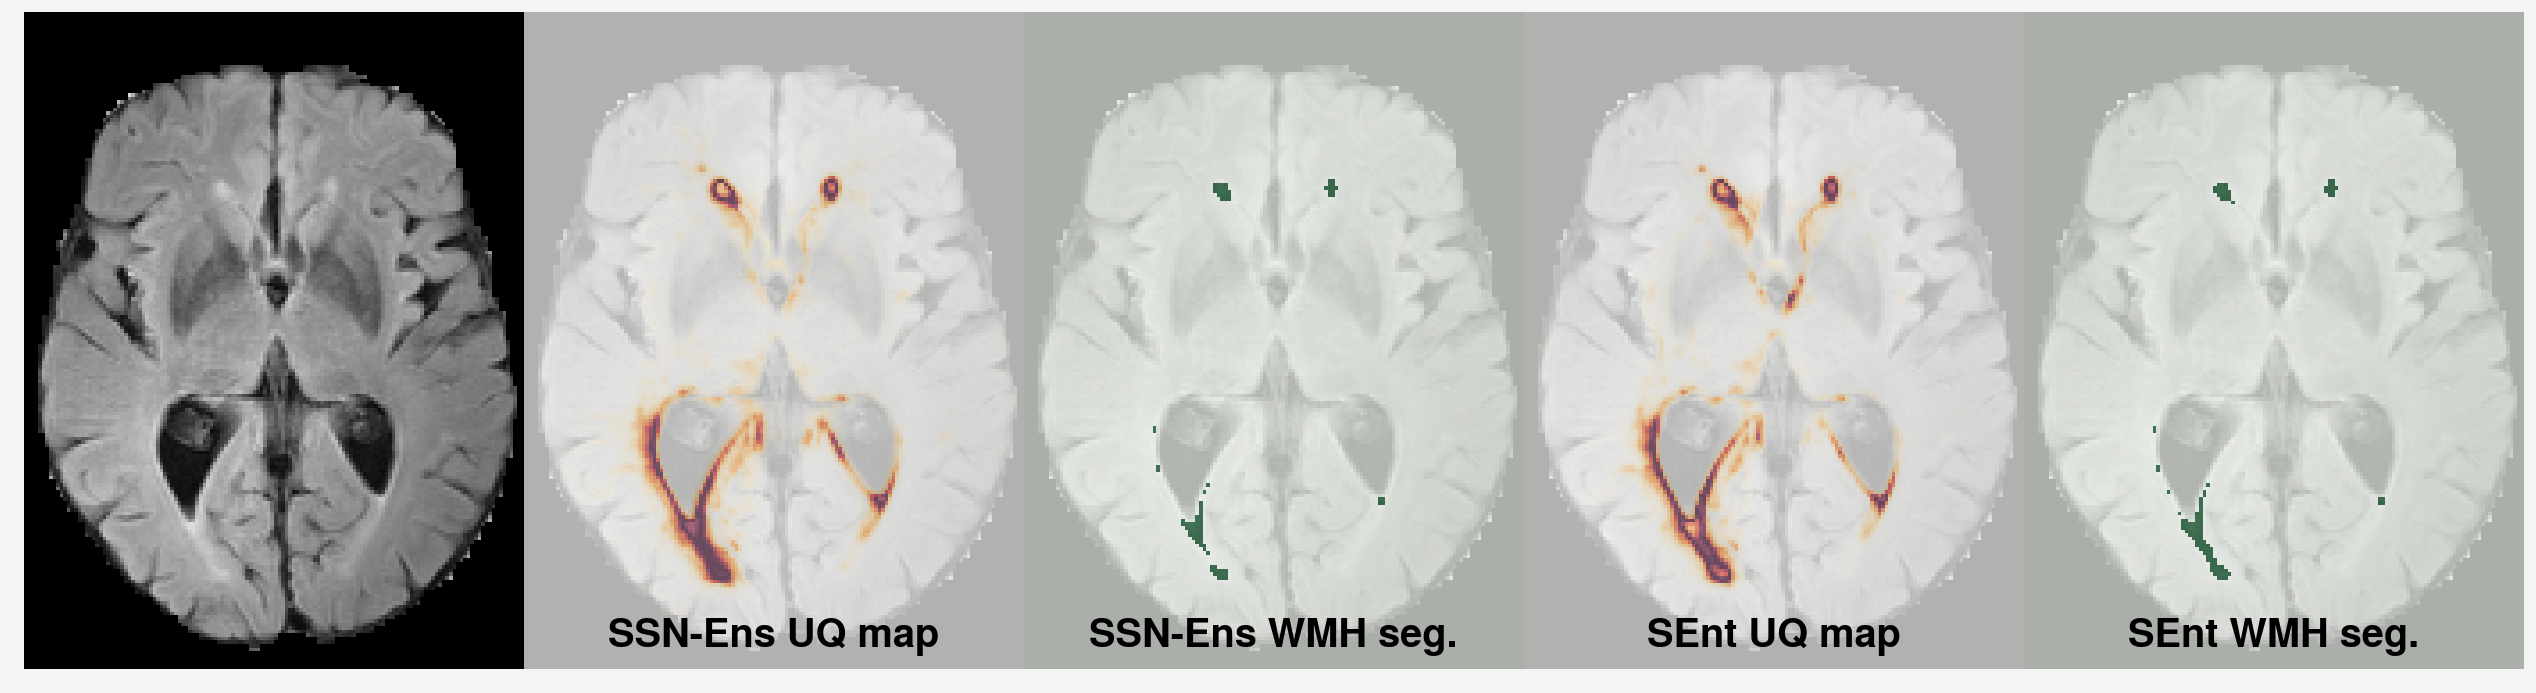

In [17]:
plot_brain_image_singlesice(ADNI_ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], '002_S_1261', adni_data['ssn_ens'], reverse_IDs_map, islice=26, r1=20, r2=10, figtitles=True, savetitle="failure:bias field example")


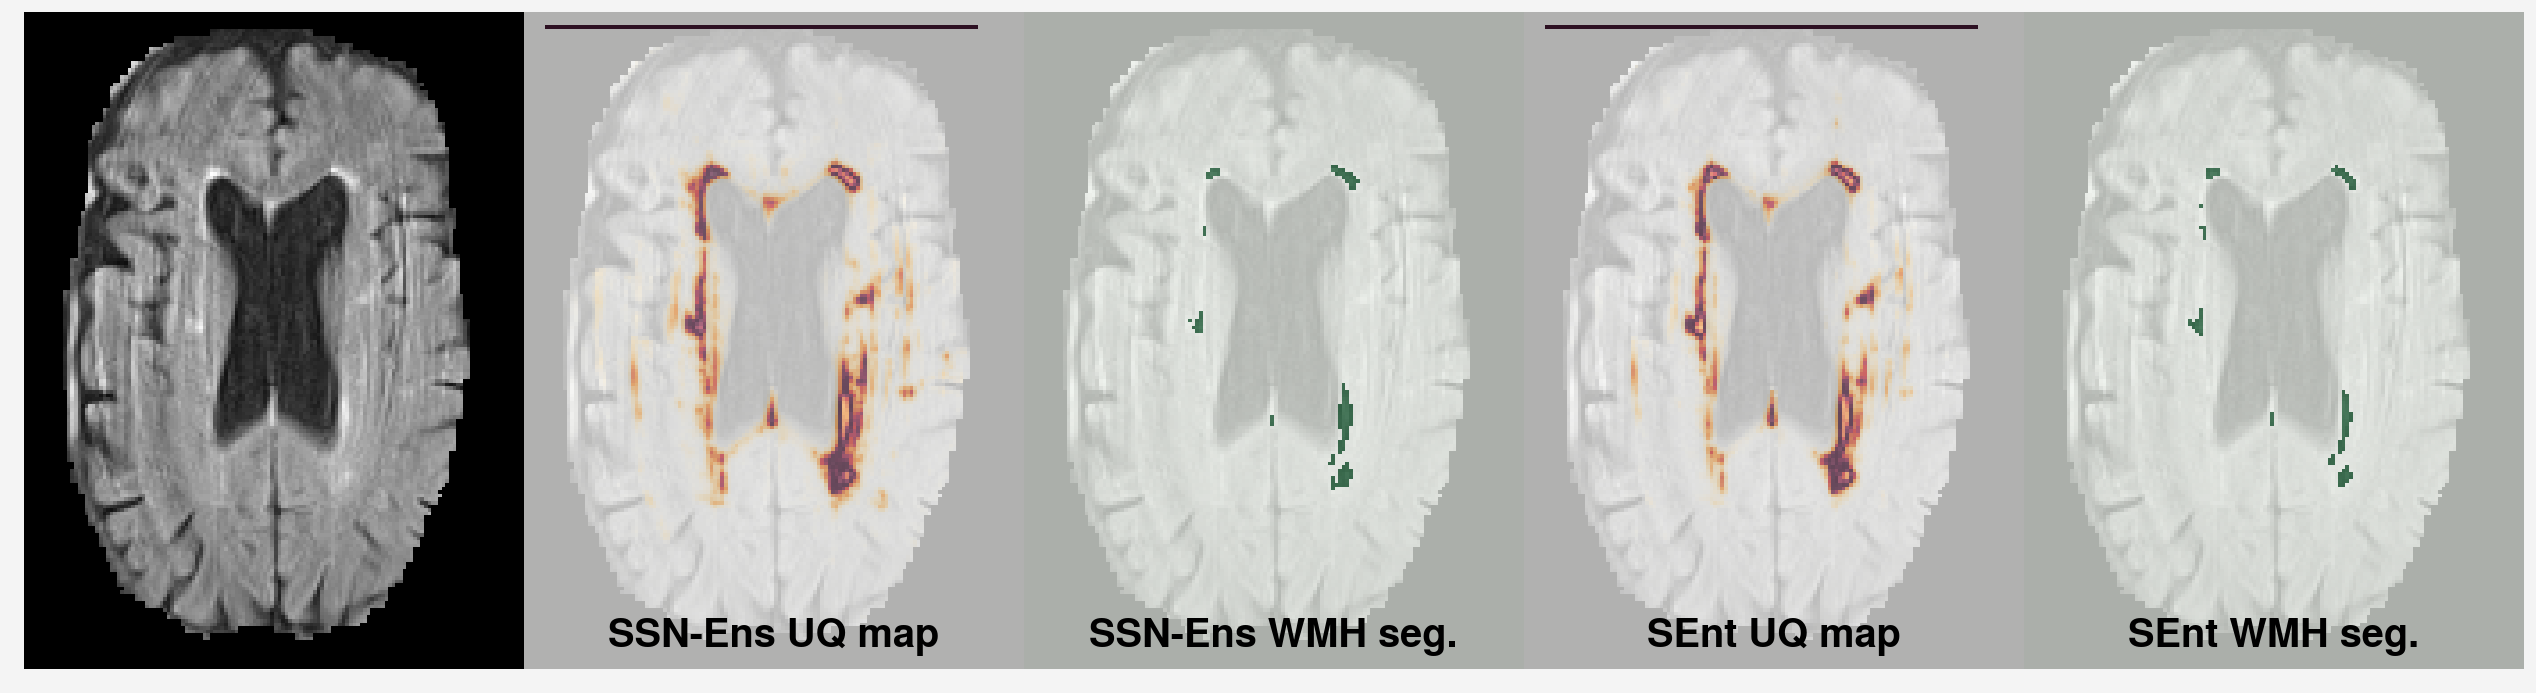

In [18]:
plot_brain_image_singlesice(ADNI_ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], '009_S_4741', adni_data['ssn_ens'], reverse_IDs_map, islice=28, r1=20, r2=10, figtitles=True, savetitle="failure:head motion example")